# Data flow through the neural network
The objective of this notebook is to illustrate how exactly data passes through a network during training (and operation) that we build out of simple pieces.  During training, the flow of information is separated into a forward pass (predict) and backward pass (adjust).  During operational mode, only the forward pass is used.

In addition, we will perform gradient descent on the constructed network.

At the same time, we show how to build a network out of Torch modules (shown previously)

Steps:

1. We build a simple network and manually go through a forward and backward pass [one time only]
2. We compare our results to Torch to verify we (and Torch) did the same thing.
3. We perform a parameter update again manually and using a Torch function.

In [1]:
-- let's discuss neural networks and layers in torch
require 'nn'
Plot = require 'itorch.Plot'
print('ready')

ready	


In [2]:
-- ensure repeatability
torch.manualSeed(1234)

In [3]:
-- let's build a single layer, which processes inputs via a linear combination and then applies tanh
-- which passes the data to layer 2 that does the same thing but with less weights
net = nn.Sequential()
-- this is 'layer 1'
net:add(nn.Linear(10, 5))
net:add(nn.Tanh())
-- this is 'layer 2'
net:add(nn.Linear(5, 1))
net:add(nn.Tanh())

In [4]:
-- let's print a textual representation of this network
print(net)

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> output]
  (1): nn.Linear(10 -> 5)
  (2): nn.Tanh
  (3): nn.Linear(5 -> 1)
  (4): nn.Tanh
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        nn.Linear(10 -> 5)
        {
          gradBias : DoubleTensor - size: 5
          weight : DoubleTensor - size: 5x10
          bias : DoubleTensor - size: 5


          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 5x10
          output : DoubleTensor - empty
        }
      2 : 
        nn.Tanh
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - empty
        }
      3 : 
        nn.Linear(5 -> 1)
        {
          gradBias : DoubleTensor - size: 1
          weight : DoubleTensor - size: 1x5
          bias : DoubleTensor - size: 1
          gradInput : DoubleTensor - empty
          gradWeight : DoubleTensor - size: 1x5
          output : DoubleTensor - empty
        }
      4 : 
        nn.Tanh
        {
          gradInput : DoubleTensor - empty
          output : DoubleTensor - empty
        }


    }
  output : DoubleTensor - empty
}



In [5]:
-- let's print out the network parameters [they are initially randomized by Torch]

-- module 1 weights/bias (part of layer 1)
print(net:get(1).weight)
print(net:get(1).bias)

-- module 3 weights/bias (part of layer 2)
print(net:get(3).weight)
print(net:get(3).bias)

-0.1951 -0.0015  0.0772  0.2010 -0.0394  0.0709  0.1805  0.1716  0.1771  0.2281
-0.1438 -0.2210 -0.1414 -0.1907  0.1909  0.1993  0.2898 -0.2158  0.2378 -0.2428
-0.0899 -0.3081  0.0006 -0.0083  0.1160 -0.1069  0.1345  0.1914 -0.0821 -0.2541
 0.0387 -0.2808  0.0019 -0.0363 -0.3075 -0.3022  0.1726 -0.1324  0.2420 -0.1604
-0.0855  0.1507  0.0730  0.2462 -0.2686  0.3081 -0.0830 -0.2420  0.2739 -0.0672
[torch.DoubleTensor of size 5x10]

 0.0957
-0.0299
-0.0650
 0.0241
 0.1826
[torch.DoubleTensor of size 5]

 0.2599 -0.1638 -0.0306  0.0609 -0.0578
[torch.DoubleTensor of size 1x5]

 0.3302
[torch.DoubleTensor of size 1]



## Processing input - the forward pass
- we construct a random input
- we run it through the network manually and compute the output
- we compare the output to the output produced by Torch

In [6]:
-- this is our input to the network
x = torch.Tensor(10):normal()
print(x)

-0.9701
-0.4526
 1.7667
-0.3455
 0.5392
 0.1404
-1.4901
-0.4648
-1.5187
 0.3638
[torch.DoubleTensor of size 10]



In [7]:
-- first we propagate the input x through the first layer (modules 1 & 2)
h1 = net:get(1).weight * x + net:get(1).bias
y2 = torch.tanh(h1)

-- now through the second layer (modules 3 & 4)
h3 = net:get(3).weight * y2 + net:get(3).bias
y4 = torch.tanh(h3)
print(y4)

 0.3271
[torch.DoubleTensor of size 1]



In [8]:
-- and this is how we do it in the NN torch toolkit
print(net:forward(x))

 0.3271
[torch.DoubleTensor of size 1]




## Backward pass - efficient gradient computation
- the backward pass, or backpropagation, is an efficient method of computing gradients with respect to all parameters of the network
- remember the gradient training for the perceptron? same thing here but more of it :)
- let's do this manually just this once

In [9]:
-- assume target value is zero for this (arbitrary) instance
target = torch.Tensor{0}

In [10]:
-- we compute the loss assuming we use the MSE loss (without the 1/2 factor up front) 
dloss_dy4 = (y4 - target) * 2
print(dloss_dy4)

 0.6542
[torch.DoubleTensor of size 1]



In [11]:
-- going from back to front, we compute the derivative of y2 w.r.t. h2
dy4_dh3 = - torch.pow(y4,2) + 1
print(dy4_dh3)

 0.8930
[torch.DoubleTensor of size 1]



In [12]:
-- now we need to do three things in module three (linear layer 5->1, see above)

-- common term that we can factor out for efficiency
dloss_dh3 = dloss_dy4 * dy4_dh3

-- compute gradient with respect to weights in module 3
w3_grad = (y2 * dloss_dh3):reshape(1,5)
print(w3_grad)

-- compute gradient with respect to bias in module 3
b3_grad = torch.Tensor{1 * dloss_dh3}
print(b3_grad)

-- compute gradient with respect to inputs of module 3 which are also output of module 2
-- we will send this vector on to the next layer
dloss_dy2 = torch.reshape(net:get(3).weight * dloss_dh3, 5, 1)
print(dloss_dy2)

-0.1115 -0.3237 -0.0257 -0.3531 -0.0378
[torch.DoubleTensor of size 1x5]

 0.5842
[torch.DoubleTensor of size 1]

 0.1519
-0.0957
-0.0179
 0.0356
-0.0338
[torch.DoubleTensor of size 5x1]



In [13]:
-- now the next layer is up (module 2 - tanh)
-- this is a scalar function applied in parallel, so derivatives here are elementwise
dy2_dh1 = -torch.pow(y2,2) + 1
print(dy2_dh1)

 0.9636
 0.6930
 0.9981
 0.6347
 0.9958
[torch.DoubleTensor of size 5]



In [14]:
-- and finally module 1, which is a linear layer
-- reminder: the input to this layer is x itself
dloss_dh1 = torch.cmul(dloss_dy2, dy2_dh1)
print(dloss_dh1)
w1_grad = dloss_dh1 * x:reshape(1,10)
print(w1_grad)
b1_grad = dloss_dh1
print(b1_grad)

 0.1463
-0.0663
-0.0178
 0.0226
-0.0336
[torch.DoubleTensor of size 5x1]

-0.1420 -0.0662  0.2585 -0.0506  0.0789  0.0206 -0.2180 -0.0680 -0.2222  0.0532
 0.0643  0.0300 -0.1172  0.0229 -0.0358 -0.0093  0.0988  0.0308  0.1007 -0.0241
 0.0173  0.0081 -0.0315  0.0062 -0.0096 -0.0025  0.0265  0.0083  0.0271 -0.0065
-0.0219 -0.0102  0.0399 -0.0078  0.0122  0.0032 -0.0337 -0.0105 -0.0343  0.0082
 0.0326  0.0152 -0.0594  0.0116 -0.0181 -0.0047  0.0501  0.0156  0.0511 -0.0122
[torch.DoubleTensor of size 5x10]



 0.1463
-0.0663
-0.0178
 0.0226
-0.0336
[torch.DoubleTensor of size 5x1]



### And now let Torch do the work for us
We first let torch do the backprop and then verify that the results match.

In [17]:
-- remember the MSE (mean square error) criterion?
-- code here: https://github.com/torch/nn/blob/master/MSECriterion.lua
-- C/CUDA code here: https://github.com/torch/nn/blob/master/generic/MSECriterion.c
loss = nn.MSECriterion()
print(loss:updateOutput(y4, target))

-- DO NOT FORGET THIS, backward() accumulates gradient parameters
net:zeroGradParameters()
net:backward(x, loss:backward(y4, target))

-- yes, that's it :)

0.10699431113771	


In [18]:
-- let's check the gradient for the weights in the 3rd layer
print(w3_grad:reshape(1,5))
print(net:get(3).gradWeight)

-0.1115 -0.3237 -0.0257 -0.3531 -0.0378
[torch.DoubleTensor of size 1x5]

-0.1115 -0.3237 -0.0257 -0.3531 -0.0378
[torch.DoubleTensor of size 1x5]



In [19]:
-- let's check the bias
print(b3_grad)
print(net:get(3).gradBias)

 0.5842
[torch.DoubleTensor of size 1]

 0.5842
[torch.DoubleTensor of size 1]



In [20]:
-- let's look at the gradient for biases in the first level
print(b1_grad)
print(net:get(1).gradBias)

 0.1463
-0.0663
-0.0178
 0.0226
-0.0336
[torch.DoubleTensor of size 5x1]

 0.1463
-0.0663
-0.0178
 0.0226
-0.0336
[torch.DoubleTensor of size 5]



## Parameter updates via gradient descent

In [21]:
-- now, we can perform the gradient descent training manually, using a learning rate
lambda = 0.01
netc = net:clone()

netc:get(3).weights = netc:get(3).weight - w3_grad * 0.01
netc:get(3).bias = netc:get(3).bias - b3_grad * 0.01
netc:get(1).weights = netc:get(1).weight - w1_grad * 0.01
netc:get(1).bias = netc:get(1).bias - b1_grad * 0.01

In [22]:
-- let's do the same in torch on the original network
net:updateParameters(lambda)

In [23]:
-- and compare results, e.g. first layer bias
print(netc:get(1).bias)
print(net:get(1).bias)

 0.0943
-0.0292
-0.0648
 0.0239
 0.1829
[torch.DoubleTensor of size 5]

 0.0943
-0.0292
-0.0648
 0.0239
 0.1829
[torch.DoubleTensor of size 5]



# A catalog of transfer functions
- we divide transfer functions into
  - intrinsically scalar: Tanh, HardTanh, Sigmoid, ReLU, SoftPlus
  - intrinsically vector: SoftMax, LogSoftMax
- these can all be used with the Linear module (which provides the input weights to the layer)

In [72]:
-- we will use x as input to the layer
xs = torch.range(-50,50) / 10

## Intrinsically scalar transfer functions
- [Overview](https://github.com/torch/nn/blob/master/doc/transfer.md)
- Tanh = hyperbolic tangent [y = (exp(x) - exp(-x)) / (exp(x) + exp(-x))]
- HardTanh - a piecewise linear approximation to Tanh
- Sigmoid layer [y = 1 / (1 + exp(-x))]
- ReLU layer - Rectified Linear layer [y = max(x, 0)], [ReLU/PReLU results](http://arxiv.org/pdf/1502.01852v1.pdf)
- SoftPlus layer - a 'soft' version of ReLU

In [73]:
ys1 = nn.Tanh():forward(xs)
ys2 = nn.HardTanh():forward(xs)

ys3 = nn.Sigmoid():forward(xs)

p = Plot():line(xs,ys1,'red','Tanh'):line(xs,ys2,'green','HardTanh'):line(xs,ys3,'blue','Sigmoid')
p:title('Tanh/HardTanh/Sigmoid activation functions'):legend(true):draw()

[string "ys1 = nn.Tanh():forward(xs)..."]:6: attempt to call global 'Plot' (a nil value)
stack traceback:
	[string "ys1 = nn.Tanh():forward(xs)..."]:6: in main chunk
	[C]: in function 'xpcall'
	...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:179: in function <...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:143>
	...lka/Packages/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/vejmelka/.ipython/profile_defaul..."]:1: in main chunk: 

In [74]:
ys4 = nn.ReLU():forward(xs)
ys5 = nn.SoftPlus():forward(xs)
p = Plot():line(xs,ys4,'red','ReLU'):line(xs,ys5,'blue','SoftPlus'):title('ReLU and SoftPlus transfer functions'):legend(true):draw()

[string "ys4 = nn.ReLU():forward(xs)..."]:3: attempt to call global 'Plot' (a nil value)
stack traceback:
	[string "ys4 = nn.ReLU():forward(xs)..."]:3: in main chunk
	[C]: in function 'xpcall'
	...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:179: in function <...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:143>
	...lka/Packages/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/vejmelka/.ipython/profile_defaul..."]:1: in main chunk: 

## Intrinsically vector transfer functions
- these layers are typically used in the last (output layer) of the network
- for multiclass classification problems - [SoftMax](https://github.com/torch/nn/blob/master/doc/transfer.md#softmax) layer
- logarithmic verions of above: LogSoftMax, LogSigmoid are useful in conjunction with some loss functions

# Convolutional layers
- general info on [convolutional layers](https://github.com/torch/nn/blob/master/doc/convolution.md)
- [nn.TemporalConvolution](https://github.com/torch/nn/blob/master/doc/convolution.md#nn.TemporalConvolution) is a 1D convolutional operator suitable for e.g. time series
- [nn.SpatialConvolution](https://github.com/torch/nn/blob/master/doc/convolution.md#spatialconvolution) layer is a 2D convolution (for use with images)
- max pooling and subsampling layers

In [75]:
conv = nn.TemporalConvolution(1, 1, 2)
print(conv)
conv.weight[1][1] = -1
conv.weight[1][2] = 1
conv.bias[1] = 0
print(conv.weight)
print(conv.bias)

nn.TemporalConvolution
{
  gradBias : DoubleTensor - size: 1
  dW : 1
  bias : DoubleTensor - size: 1
  gradInput : DoubleTensor - empty
  weight : DoubleTensor - size: 1x2
  inputFrameSize : 1
  gradWeight : DoubleTensor - size: 1x2
  outputFrameSize : 1
  kW : 2
  output : DoubleTensor - empty
}
-1  1
[torch.DoubleTensor of size 1x2]

 0
[torch.DoubleTensor of size 1]



In [76]:
xs = torch.rand(50,1) * 0.2
xs[{{15,30},1}] = xs[{{15,30},1}] + 1
ys = conv:forward(xs)
noutput = (xs:size(1) - 2) / 1 + 1

In [77]:
-- reshape the vectors for plotting
time = torch.range(1,noutput)
xsp = xs[{{2,noutput+1},{}}]:reshape(noutput)
ysp = ys:reshape(noutput)

In [78]:
p = Plot():title('Effect of 1D conf [shifted]'):line(time,xsp+1,'blue','input'):line(time, ysp-1,'red','output')
p:xaxis('samples'):yaxis('signal'):legend(true):draw()

[string "p = Plot():title('Effect of 1D conf [shifted]..."]:1: attempt to call global 'Plot' (a nil value)
stack traceback:
	[string "p = Plot():title('Effect of 1D conf [shifted]..."]:1: in main chunk
	[C]: in function 'xpcall'
	...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:179: in function <...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:143>
	...lka/Packages/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Packages/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...lka/Packages/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/vejmelka/.ipython/profile_defaul..."]:1: in main chunk: 

In [79]:
-- snippet shamelessly ripped from https://github.com/torch/tutorials/blob/master/A_datasets/mnist.lua 
-- load the training data (downloads when first used)
tar = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/mnist.t7.tgz'

if not paths.dirp('mnist.t7') then
   print('==> downloading dataset')
   os.execute('wget ' .. tar)
   os.execute('tar xvf ' .. paths.basename(tar))
end
test_file = 'mnist.t7/test_32x32.t7'

----------------------------------------------------------------------
print('==> loading dataset')

-- We load the dataset from disk, it's straightforward
test_data = torch.load(test_file,'ascii')

==> loading dataset	


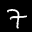

Size of the input is 1 x 32 x 32	


In [80]:
inp2d = test_data.data[{244}]:type('torch.DoubleTensor')
print('Size of the input is ' .. inp2d:size(1) .. ' x ' .. inp2d:size(2) .. ' x ' .. inp2d:size(3))
itorch.image(inp2d)

In [81]:
conv2 = nn.SpatialConvolution(1, 1, 3, 3)
print(conv2)
conv2.weight[{1,1,{1,3},{1,3}}] = -1
conv2.weight[{1,1,2,2}] = 8
conv2.bias[1] = 0

In [82]:
out2d = conv2:forward(inp2d)
itorch.image(out2d)
print(out2d:size())


  1
 30
 30
[torch.LongStorage of size 3]



# Important loss functions [or criteria]
- [Mean Square Error](https://github.com/torch/nn/blob/master/doc/criterion.md#nn.MSECriterion)
- [Negative Log Likelihood](https://github.com/torch/nn/blob/master/doc/criterion.md#nn.ClassNLLCriterion) (for use with LogSoftMax layer as it expects logarithms on input
- [Cross Entropy](https://github.com/torch/nn/blob/master/doc/criterion.md#crossentropycriterion) combines LogSoftMax with NLL